### 분류 실습 - 캐글 신용카드 사기 검출
캐글 신용카드 거래내용이 포함된 데이터 셋을 아래 사이트에서 다운받아 다음 사항을 수행하세요.

https://www.kaggle.com/mlg-ulb/creditcardfraud

- 데이터 설명<br><br>
    - 데이터 세트에는 유럽 카드 소지자가 2013년 9월에 신용 카드로 거래한 내용이 포함되어 있습니다. 이 데이터 세트는 284,807건의 거래 중 492건의 사기가 발생한 이틀 동안 발생한 거래를 보여줍니다. 데이터 세트는 매우 불균형하며 긍정적 클래스(사기)는 모든 거래의 0.172%를 차지합니다.<br><br>

    - 여기에는 PCA 변환의 결과인 숫자 입력 변수만 포함됩니다. 안타깝게도 기밀 문제로 인해 데이터에 대한 원래 기능과 추가 배경 정보를 제공할 수 없습니다. 
   - 기능 V1, V2, … V28은 PCA로 얻은 주요 구성 요소이며 PCA로 변환되지 않은 유일한 기능은 '시간'과 '양'입니다. 
   - 기능 '시간'에는 각 트랜잭션과 데이터 세트의 첫 번째 트랜잭션 사이에 경과된 초가 포함됩니다.
   - 'Amount' 기능은 거래 금액이며, 이 기능은 예제 종속 비용에 민감한 학습에 사용할 수 있습니다. 
   - 기능 'Class'는 응답 변수이며 사기의 경우 값 1, 그렇지 않은 경우 0을 취합니다.

- 데이터 전처리 후 로지스틱 리그레션을 적용한 모델 학습 및 평가(정확도, 정밀도, 재현율, F1 score, AUC)
- Amount 피처를 정규분포 및 로그 변환 후 모델 학습 및 평가
- 상관성이 높은 피처 한개를 선택하여 이상치 데이터 제거 후 모델 학습 및 평가
- SMOTE 오버 샘플링 적용 후 모델 학습 및 평가
- SMOTE 적용 시 인사이트 요약

##### 데이터 사전 이해
- 해당 데이터 세트의 레이블인 Class 속성은 매우 불균형한 분포를 가지고 있다.
    - Class는 0과 1로 분류되는데 0이 사기가 이닌 정상적인 신용카드 트랜잭션 데이터, 1은 신용카드 사기 트랜잭션을 의미한다.
    - 전체 데이터의 약 0.172%만이 레이블 값이 1인 사기 트랜잭션이다.
    - 일반적으로 사기 검출이나 이상 검출과 같은 데이터 세트는 이처럼 레이블 값이 극도로 불균형한 분포를 가지기 쉽다. 

##### 오버 샘플링
- SMOTE 
    - 적은 데이터 세트에 있는 개별 데이터들의 K 최근접 이웃을 찾아서 이 데이터와 K개 이웃들의 차이를 일정 값으로 만들어서 기존 데이터와 약간 차이가 나는 새로운 데이터를 생성하는 방식

In [1]:
# SMOTE를 구현할 패키지
!pip install imbalanced-learn

### 분석 프로세스

1. 데이터 뜯어보기

2. 학습용/테스트용 데이터 나누기

3. 데이터 전처리 후 모델 학습/예측/평가

  3-1. 데이터 분포도 변환

  3-2. 이상치 데이터 제거

4. 결과


1. 데이터 뜯어보기

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

card_df=pd.read_csv('./dataset/creditcard.csv')
display(card_df.head(5))
display(card_df.shape)
display(card_df.columns)

# 데이터는 284807행, 31열로 이루어져 있고 칼럼 중 Class는 1이 사기이고 0이 정상 데이터를 뜻하는 target 값이고
# Amount 피처는 신용카드 사용 금액을 의미합니다.
# Time 피처는 의미가 없는 피처임으로 삭제해도 될 것 같습니다.
# V1~V28 피처는 의미를 알 수 없습니다. 개인정보에 관련된 피처 같습니다.

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


(284807, 31)

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [7]:
# 결측치가 없는 깔끔한 데이터
print('결측치',card_df.isna().sum())

결측치
Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64


In [8]:
# 데이터의 구조를 살펴봤으니 Class 피처와 Amount 피처에 대해 자세히 알아 본다.
print('클래스 값 분포')
print(card_df.iloc[:,-1].value_counts())  # card_df.iloc[:,-1] -> class열을 의미함 그것의 구성요소 -> value_counts() 
# 클래스 값들이 상당히 불균형한 형태  why? 당연히 사기인 데이터에 비해 정상인 데이터가 많기 때문이다.

클래스 값 분포
0    284315
1       492
Name: Class, dtype: int64


<AxesSubplot:xlabel='Amount', ylabel='Density'>

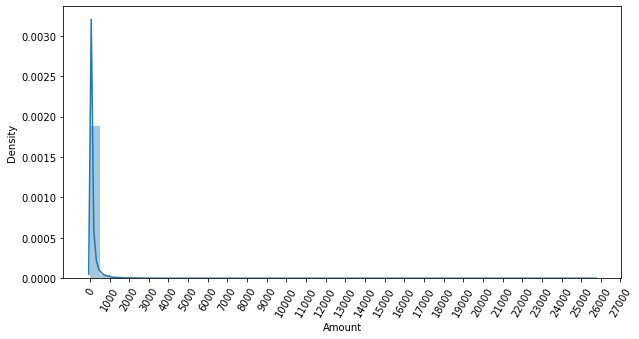

In [9]:
# Amount 피처를 살펴보겠습니다.
import seaborn as sns
plt.figure(figsize=(10,5))
plt.xticks(range(0,30000,1000),rotation=60)
sns.distplot(card_df['Amount'])
# 카드 사용 금액이 0에서 1000달러 이하인 데이터가 대부분이다. 
# 신용 카드로 10만원 이상 쓰는 사람이 많지 않아 보인다.

2. 학습용/테스트용 데이터 나누기

In [2]:
# 데이터를 뜯어봤으니 학습과 예측을 위해 데이터를 학습용과 테스트용으로 나눠야 한다.
# 이때, 불균형한 데이터이기 때문에 Stratified 방식으로 나눠야 Class의 분포가 균등하게 나눠질 수 있다.
# 데이터의 원본을 유지한 채로 데이터를 전처리하고 나누기 위해 get_preprocessed_df 와 get_train_test_dataset 함수를 만들어 진행
from sklearn.model_selection import train_test_split

# 인자로 입력받은 DataFrame을 복사한 뒤 Time 칼럼만 삭제하고 복사된 DataFrame을 반환
def get_preprocessed_df(df=None):
    df_copy = df.copy()
    df_copy.drop('Time',axis=1,inplace=True)
    return df_copy

# 데이터를 학습용과 테스트용으로 나누는 함수 
# get_train_test_dataset는 get_preprocessed_df를 호출한 뒤 학습 피처/레이블 데이터 세트, 테스트 피처/레이블 데이터 세트를 반환
def get_train_test_dataset(df=None):
    # 인자로 입력된 DataFrame의 사전 데이터 가공이 완료되고 복사된 DataFrame 반환
    df_copy = get_preprocessed_df(df)
    X_features = df_copy.iloc[:,:-1] # 독립변수에 Class 빼고 전체 열 -> (행, 열 slicing)
    y_target = df_copy.iloc[:,-1] # 종속변수에 Class열만 선택 -> (행 slicing, 열은 선택)
    X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.3, random_state=0, stratify=y_target)
    return X_train,X_test,y_train,y_test

X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

print('학습 데이터 레이블 값 비율')
print(y_train.value_counts()/y_train.shape[0]*100)
print('테스트 데이터 레이블 값 비율')
print(y_test.value_counts()/y_test.shape[0]*100)

# 테스트 세트를 전체의 30%가 되도록 나누었고 나누어진 target값의 비율은 위와 같다.
# Straified 방식으로 나누었기에 매우 적었던 Class 값이 1인 데이터가 
# 학습 데이터와 테스트 데이터에 0.172%와 0.173%로 큰 차이 없이 잘 분할된 것을 확인할 수 있다.

학습 데이터 레이블 값 비율
0    99.827451
1     0.172549
Name: Class, dtype: float64
테스트 데이터 레이블 값 비율
0    99.826785
1     0.173215
Name: Class, dtype: float64


3. 데이터 전처리 후 모델 학습/예측/평가

In [10]:
# 각 데이터 전처리 후 모델의 예측 성능 평가를 매번 할 것이기 때문에
# get_model_train_eval() 함수를 만들어 중복되는 작업을 편리하게 하도록 한다.
# 평가는 정확도, 정밀도, 재현율, f1 스코어, roc-auc 스코어를 통해 진행한다.

from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score, roc_auc_score
    
def get_model_train_eval(model, feature_train=None, feature_test=None, target_train=None, target_test=None):
    model.fit(feature_train, target_train)
    pred = model.predict(feature_test)
    pred_proba = model.predict_proba(feature_test)[:,1] # Class 예측값을 pred_proba에 담기
    
    confusion = confusion_matrix(target_test, pred)
    accuracy = accuracy_score(target_test, pred)
    precision = precision_score(target_test, pred)
    recall = recall_score(target_test, pred)
    f1 = f1_score(target_test, pred)
    roc_auc = roc_auc_score(target_test, pred_proba)
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1: {3:.4f}, AUC: {4:.4f}'.format(accuracy,precision,recall,f1,roc_auc))

### LightGBM 하이퍼 파라미터
- num_iterations(default=100) : 반복 수행하려는 트리의 개수
    - 크게 지정할수록 예측 성능이 높아질 수 있으나, 너무 크게 지정하면 오히려 과적합으로 성능이 저하 될 수 있다.
    - 사이킷런 GBM과 XGBoost의 사이킷런 호환 클래스의 n_estimators와 같은 파라미터이므로 LigthGBM 사이킷런 호환 클래스에서는 n_estimators로 이름이 변경된다.<br><br>
    
- learning_rate(default= 0.1) : 0에서 1사이의 값을 지정하며 부스팅 스텝을 반복적으로 수행할 때 업데이트되는 학습률 값이다.
일반적으로 n_estimators를 크게하고 learning_rate를 작게 해서 예측 성능을 향상시킬 수 있으나, 마찬가지로 과적합 이슈와 학습 시간이 길어지는 부정적인 영향도 고려해야 한다. 
   - GBM, XGBoost의 learning_rate와 같은 파라미터이다.<br><br>

- max_depth(default= -1) : 트리 기반 알고리즘의 max_depth와 같다. 0보다 작은 값을 지정하면 깊이에 제한이 없다.
트리 기반의 Level wise 방식과 다르게 LightGBM은 Leaf wise 기반이므로 깊이가 상대적으로 더 깊다.<br><br>

- min_data_in_leaf(default= 20) : 결정 트리의 min_samples_leaf와 같은 파라미터이다. 하지만 사이킷런 래퍼 LightGBM클래스인 LightGBMClassifier에서는 min_child_samples 파라미터로 이름이 변경된다. 최종 결정 클래스인 리프 노드가 되기 위해서 최소한으로 필요한 레코드 수이며, 과적합을 제어하기 위한 파라미터이다.<br><br>

- num_leaves(default= 31) : 하나의 트리가 가질 수 있는 최대 리프 개수이다.<br><br>

- boosting(default= gbdt) : 부스팅의 트리를 생성하는 알고리즘을 기술한다.<br><br>
    - gbdt : 일반적인 Gradient Boost Decision Tree
    - rf : RandomForest<br><br>
    
- bagging_fraction(default = 1.0) : 개별 트리를 학습할 때마다 무작위로 선택하는 피처(칼럼, 속성)의 비율이다.
 과적합을 막기 위해 사용된다.
     * GBM의 max_features와 유사하며 XGBClassifier의 colsample_bytree와 똑같기 때문에 LigthGBM Classifier에서는 동일하게 closample_bytree로 변경된다.<br><br>

- lambda_l2(default = 0.0) : L2 regulation 제어를 위한 값이다. 피처 개수가 많을 경우 적용을 검토하며 값이 클수록 과적합 감소 효과가 있다. XGBClassifier의 reg_lambda와 동일하므로 LigthGBMClassifier에서는 reg_lambda로 변경된다.<br><br>

- lambda_L1(default = 0.0) : L1 regulation 제어를 위한 값이다. L2와 마찬가지로 과적합 제어를 위한 것이며, XGBClassifier의 reg_alpha와 동일하므로 LightGBMClassifier에서는 reg_alpha로 변경된다.

### Learning Task 파라미터
- objective : 최솟값을 가져야 할 손실함수를 정의한다. XGBoost의 objective 파라미터와 동일하다. 애플리케이션 유형, 즉 회귀, 다중 클래스 분류, 이진 분류인지에 따라서 objective인 손실함수가 지정된다.

### 하이퍼 파라미터 튜닝 방안
##### num_leaves의 개수를 중심으로 min_child_samples(min_data_in_leaf), max_depth를 함께 조정하면서 모델의 복잡도를 줄이는 것이 기본 튜닝 방안

- num_leaves는 개별 트리가 가질 수 있는 최대 리프의 개수이고 LightGBM 모델의 복잡도를 제어하는 주요 파라미터이다. 일반적으로 num_leaves의 개수를 높이면 정확도가 높아지지만, 반대로 트리의 깊이가 깊어지고 모델의 복잡도가 커져 과적합 영향도가 커진다.<br><br>

- min_data_in_leaf는 사이킷런 래퍼 클래스에서는 min_child_samples로 이름이 바뀐다. 과적합을 개선하기 위한 중요한 파라미터이다. num_leaves와 학습 데이터의 크기에 따라 달라지지만, 보통 큰 값으로 설정하면 트리가 깊어지는 것을 방지한다.<br><br>

- max_depth는 명시적으로 깊이의 크기를 제한한다. num_leaves, min_data_in_leaf와 결합해 과적합을 개선하는데 사용한다.<br><br>

- learning_rate를 작게하면서 n_estimators를 크게 하는 것은 부스팅 꼐열 튜닝에서 가장 기본적인 튜닝 방안이므로 이를 적용하는 것도 좋다. 그렇다고 n_estimators를 너무 크게 하는 것은 과적합으로 오히려 성능이 저하될 수 있음을 유념한다.

In [13]:
# 데이터 전처리 후의 성능을 비교해보기 위해 원본 데이터를 모델을 학습시키고 예측하고 모델의 예측 성능을 평가한다.
# 모델은 분류에 대표적으로 쓰이는 로지스틱 회귀 모델과 앙상블 방법인 LightGBM 모델을 사용한다.
 
from sklearn.linear_model import LogisticRegression # 로지스틱 회귀
from lightgbm import LGBMClassifier # LightGBM

lr_clf = LogisticRegression()
# 본 예제와 같이 레이블 값이 극도로 불균형한 분포를 이루는 경우 boost_from_average=Fasle로 설정해야 한다.
# True로 설정하면 재현률 및 ROC-AUC 성능을 매우 크게 저하시킨다.
# n_jobs=-1이면 모든 cpu core를 병렬로 사용하여 n_estimators갯수로 주어진 LGBMClassifier 트리를 병렬로 빠르게 만들어서 학습 수행이 가능합 
lgbm_clf = LGBMClassifier(n_estimators= 1000, num_leaves= 64, n_jobs= -1, boost_from_average=False)

print('로지스틱 회귀 성능')
get_model_train_eval(lr_clf, X_train, X_test, y_train, y_test)
print('LightGBM 성능')
get_model_train_eval(lgbm_clf, X_train, X_test, y_train, y_test)
# 재현율 0.7568, AUC는 0.9790으로 로지스틱 회귀보다 LightGBM 성능이 좋게 나옴

로지스틱 회귀 성능
정확도: 0.9992, 정밀도: 0.8738, 재현율: 0.6081, F1: 0.7171, AUC: 0.9597
LightGBM 성능
정확도: 0.9995, 정밀도: 0.9573, 재현율: 0.7568, F1: 0.8453, AUC: 0.9790


### 정밀도(precision), 재현율(recall), F1 Score, ROC_AUC
- 정밀도 : TP / (TP + FP) 예측과 실제 값이 모두 Positive / Positive로 예측한 것
- 재현율 : TP / (TP + FN) 예측과 실제 값이 모두 Positive / 실제 값이 Positive<BR><BR>

-  재현율은 보통 실제값이 Positive일 때 예측한 값이 Positive일 경우가 매우 중요한 상황일 때 사용된다. 단적인 예로, 암 판단 분류 예측을 하는 문제에 있어서 실제로 암이 걸렸는데 예측을 암이 걸리지 않았다고 판단하게 되면 수반되는 위험이 매우 커지게 된다.<BR><BR>

 

- 반대로 정밀도는 모델이 Positive라고 예측했을 때 실제값이 Negative일 때 위험이 수반되는 경우에 사용된다. 예시로는 스팸메일 분류를 들 수 있다. 만약 분류 모델이 중요한 업무내용을 담고 있는 메일(Negative)을 스팸메일(Positive)이라고 분류하게 된다면 중요한 업무내용이 전달되지 못하는 위험상황이 발생한다.<BR><BR>

 

- 그런데 이 재현율과 정밀도 사이는 Trade-off라는 관계가 존재한다. Trade-off란, 쉽게 말해서 "두 마리 토끼를 다 잡을 순 없다" 라는 의미이다. 즉, 정밀도와 재현율을 둘 다 모두 최대값으로 할 수가 없다는 것이다. 정밀도가 극도로 높게 된다면 재현율은 낮아질 수 밖에 없고 반대로 재현율이 극도로 높게 된다면 정밀도값은 낮아질 수 밖에 없다. 마치 머신러닝에서 Bias와 Variance를 둘 다 동시에 높일 수 없는 것처럼 말이다.<BR><BR>

 

- 이진분류인 상황에서 Positive(1) label로 분류하는 확률값의 디폴트값은 0.5이다. 이 디폴트값을 낮추고 높여줌으로써 정밀도와 재현율을 조절할 수가 있다. 이 디폴트값을 '분류 결정 임계값(threshold)' 라고 부른다. 만약 이 임계값을 0.5에서 0.4로 낮추어 준다면 정밀도와 재현율에는 어떤 변화가 발생할까?<BR><BR>

 

- 임계값을 낮추게 된다는 것은 그만큼 모델이 Positive라고 예측하는 횟수가 많아진다는 것과 동일한 의미이다. 재현율의 의미는 실제값이 Positive인데 모델이 Positive로 예측한 비율이다. 따라서 분모의 FN(실제값이 Positive인데 모델이 Negative라고 예측한 횟수) 값이 낮아질 수 밖에 없다. 따라서 임계값을 낮추게 되면 재현율은 커진다.<BR><BR>

 

- 반대로 정밀도는 모델이 Positive 라고 예측했을 때 실제값이 Positive인 비율이다. 그래서 분모의 FP(모델이 Positive라고 예측했을 때 실제값이 Negative인 횟수) 값이 커지게 된다. 따라서 임계값을 낮추게 되면 정밀도는 작아지게 된다.

- F1 Score : 정밀도와 재현율이 어느 한쪽으로 치우치지 않는 수치를 나타낼 때 상대적으로 높은 값을 갖는다.
- ROC_AUC : ROC Curve와 AUC는 서로 동일하다고 볼 수 있다. 하지만 표현하는 방식에 차이가 있을 뿐이다.
    - ROC Curve는 X축을 FPR(Fall-out)지표, Y축을 TPR(Recall)지표로 하는 그래프로 나타내는 방식이다. AUC는 이 ROC Curve를 점수로 환산한 방식이다. 값이 1에 가까울 수록 좋은 값이다. 
    - FPR지표란, 실제 데이터가 Negative인데 모델이 Positive라고 예측한 비율이다. FP / ( FP + TN )

### 데이터 분포도 변환 후 모델 학습/예측/평가
- 데이터 세트에서 Amount 피처의 값이 한쪽에 쏠려있는 상당히 불균형한 분포를 가지고 있다.
- 이러한 분포를 StandardScaler를 통해 정규 분포 형태로 변환해서 평가를 해본다.
- 데이터 분포도가 많이 왜곡되어 있을 경우 적용하는 중요 기법 중 하나인 로그 변환을 통해 변환하여 평가

<AxesSubplot:xlabel='Amount', ylabel='Density'>

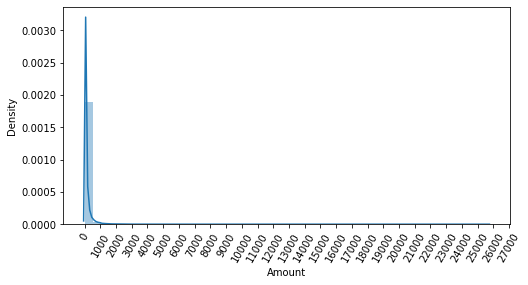

In [15]:
# Amount 피처는 신용 카드 사용 금액으로 정상/사기 트랜잭션을 결정하는 매우 중요한 속성일 가능성이 높다
# 따라서 Amount 피처의 분포도를 확인한다

import seaborn as sns
plt.figure(figsize=(8,4))
plt.xticks(range(0, 30000, 1000), rotation=60)
sns.distplot(card_df['Amount'])

# Amount 즉 카드 사용금액이 1000불 이하인 데이터가 대부분이며 27,000불까지 드물지만 많은 금액을 사용한 경우가 발생하면서
# 꼬리가 오른쪽으로 긴 형태의 분포 곡선을 가지고 있다 -> 오른쪽 꼬리가 길다 왜도 > 0 -> 평균 > 중위수 > 최빈값
# 데이터의 비대칭성이 심하니까 Amount를 표준 정규 분포 형태로 변환해줘야 한다.

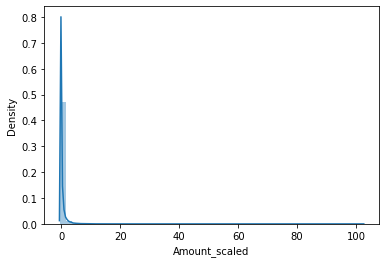

In [13]:
# 표준 정규 분포 형태로 변환한 뒤에 로지스틱 회귀의 예측 성능을 측정
from sklearn.preprocessing import StandardScaler

# 사이킷런의 StandardScaler를 이용해 정규 분포 형태로 Amount 피처값 변환하는 로직으로 수정
def get_preprocessed_df(df=None):
    df_copy = df.copy()
    scaler = StandardScaler()
    # fit_transform하려면 2차원 변환해줘야 한다 
    amount_StandardScaled = scaler.fit_transform(df_copy['Amount'].values.reshape(-1,1)) 
    
    # 변환된 Amount를 Amount_scaled로 피처명 변경후 DataFrame맨 앞 컬럼으로 입력
    df_copy.insert(0, 'Amount_scaled', amount_StandardScaled)
    
    # 기존 Time, Amount 칼럼 삭제, axis = 1 열방향
    df_copy.drop(['Time','Amount'], axis=1, inplace=True)
    sns.distplot(df_copy['Amount_scaled'])
    return df_copy

X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

# Amount 피처값이 0에서 26000이 아닌 0에서 100으로 분포가 많이 줄어들었고
# 분포의 형태는 스케일링 전의 분포와 많이 유사한 것을 볼 수 있습니다.

In [14]:
# Amount 피처값이 스케일링된 데이터 세트로 모델을 학습시키고 예측하고 모델의 예측 성능을 평가해보겠습니다. 
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier

lr_clf = LogisticRegression()
# n_estimators : 반복 수행하려는 트리의 개수
# num_leaves : 개별 트리가 가질 수 있는 최대 리프의 개수
lgbm_clf=LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)

print('로지스틱 회귀 성능')
get_model_train_eval(lr_clf,X_train,X_test,y_train,y_test)
print('LightGBM 성능')
get_model_train_eval(lgbm_clf, X_train,X_test,y_train,y_test)

# Amout 피처값을 정규화 한 데이터 세트를 이용한 모델의 성능은 원본 데이터를 이용한 모델에 비해 성능이 개선되지 않았음을 확인할 수 있습니다.

로지스틱 회귀 성능
정확도: 0.9992, 정밀도: 0.8654, 재현율: 0.6081, F1: 0.7143, AUC: 0.9702
LightGBM 성능
정확도: 0.9995, 정밀도: 0.9569, 재현율: 0.7500, F1: 0.8409, AUC: 0.9779


### 로그 변환 
- 로그 변환은 데이터 분포도가 심하게 왜곡되어 있을 경우 적용하는 중요 기법 중에 하나이다.
- 원래 log값으로 변환해 원래 큰 값을 상대적으로 작은 값으로 변환하기 때문에 데이터 분포도의 왜곡을 상당 수준 개선해 준다.
- 로그 변환은 넘파이의 log1p()함수를 이용해 간단히 변환이 가능하다.

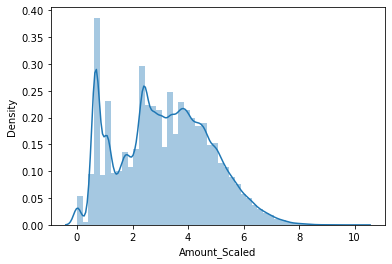

In [15]:
# 로그 변환
def get_preprocessed_df(df):
    df_copy = df.copy()
    amount_log_Scaled = np.log1p(df_copy['Amount'])
    df_copy.insert(0, 'Amount_Scaled', amount_log_Scaled)
    df_copy.drop(['Time','Amount'], axis=1, inplace=True)
    sns.distplot(df_copy['Amount_Scaled'])
    return df_copy

X_train, X_test, y_train, y_test = get_train_test_dataset(card_df) 

In [16]:
lr_clf=LogisticRegression()
lgbm_clf=LGBMClassifier(n_estimators=1000,num_leaves=64,n_jobs=-1,boost_from_average=False)

print('로지스틱 회귀 성능')
get_model_train_eval(lr_clf,X_train,X_test,y_train,y_test)
print('LightGBM 성능')
get_model_train_eval(lgbm_clf, X_train,X_test,y_train,y_test)
# Amount 피처값을 로그 변환한 데이터 세트를 이용한 모델의 성능은 원본 데이터를 이용한 모델에 비해 성능이 약간씩 개선되었음을 확인할 수 있습니다.

로지스틱 회귀 성능
정확도: 0.9992, 정밀도: 0.8812, 재현율: 0.6014, F1: 0.7149, AUC: 0.9727
LightGBM 성능
정확도: 0.9995, 정밀도: 0.9576, 재현율: 0.7635, F1: 0.8496, AUC: 0.9796


### 3-2. 이상치 데이터 제거
- 이상치 데이터란 전체 데이터의 구간, 패턴에서 벗어난 이상 값을 가진 데이터를 말합니다.
- 이상치 데이터는 머신러닝 모델의 성능을 저하시킬 가능성이 높습니다.
- 이상치를 찾는 방법 중 대표적인 방법은 IQR 방법입니다.
- IQR은 사분위 값의 Q3 - Q1 편차를 이용하는 기법입니다.
- 사분위는 전체 데이터를 값이 높은 순으로 정렬하고 이를 Q1(25%), Q2(50%), Q3(75%), Q4(100%)로 4등분한 것을 말합니다.
- 여기서 IQR이란 Q1 ~ Q3 구간을 뜻합니다.
- 이상치 데이터는 IQR에 1.5를 곱해서 생성된 범위를 벗어난 데이터를 말합니다.
- 즉, Q1-(IQR*1.5) 에서 Q3+(IQR*1.5) 구간을 벗어나면 이상치 데이터로 간주합니다.
- Box Plot으로 쉽고 직관적이게 이상치 검출 가능하다.

<AxesSubplot:>

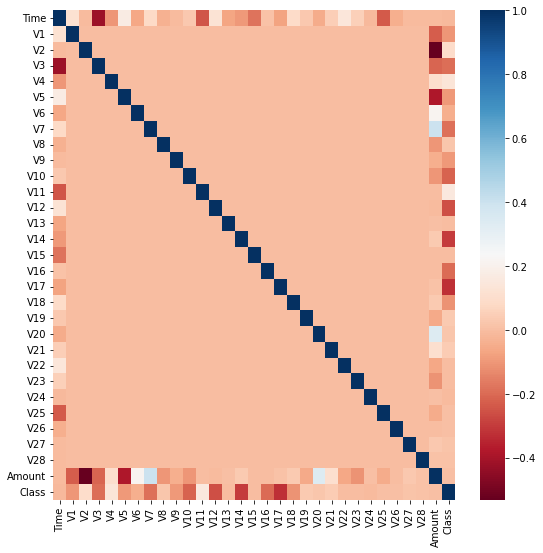

In [17]:
# 이상치 데이터를 제거하기 위해 먼저 어떤 피처의 이상치 데이터를 제거할 것인지가 필요하다.
# target값과 가장 상관성이 높은 피처들을 위주로 이상치를 제거하는 것이 바람직하다.
# why ? -> 모든 피처들의 이상치를 검출하는 것이 시간이 많이 소모되며, 결정값과 상관성이 높지 않은 피처들의 경우 이상치를 제거하더라도 크게 성능 향상에 기여하지 않기 때문이다.
# 피처들의 상관도를 히트맵을 통해 쉽게 파악
import seaborn as sns

plt.figure(figsize=(9,9))
corr=card_df.corr()
sns.heatmap(corr,cmap='RdBu') # cmap인자를 이용하여 히트 맵 색상을 바꿀 수 있다.

# 양의 상관관계가 높을수록 색깔이 진한 파란색에 가까우며, 음의 상관관계가 높을수록 색깔이 진한 빨간색에 가깝게 표현된다.
# 맨 아래줄을 보면 Class와 다른 피처들의 상관관계를 볼 수가 있는데
# 음의 상관관계가 가장 높은 피처인 V14와 V17에 대해서 이상치를 검출하고 제거해 보겠습니다. 

In [52]:
import numpy as np

# get_outlier() 함수는 인자로 DataFrame과 이상치를 검출한 칼럼을 입력 받는다.
# 가중치 1.5로 고정
def get_outlier(df, column, weight = 1.5):
    # 사기에(클래스가 1인) 해당하는 column 데이터만 추출, 1/4분위와 3/4 분위 지점을 np.percentile로 구한다
    fraud = df[df['Class']==1][column]
    quantile_25 = np.percentile(fraud.values,25) # 사기 값의 1/4 지점 -> Q1
    quantile_75 = np.percentile(fraud.values,75) # 사기 값의 3/4 지점 -> Q3
    iqr = quantile_75-quantile_25 # IQR 설정
    iqr_weighted = iqr * weight # 1.5IQR 
    lowest_val = quantile_25 - iqr_weighted # 최솟값 = Q1 -1.5IQR
    highest_val = quantile_75 + iqr_weighted # 최댓값 = Q3 + 1.5IQR
    
    # Class=1인 column에서 최댓값보다 크거나 최솟값보다 작은 Index를 반환해 outlier_index에 담는다 
    outlier_index = fraud[(fraud < lowest_val)|(fraud > highest_val)].index
    return outlier_index

outlier_index_V14 = get_outlier(card_df,'V14',1.5)
print('V14 이상치 데이터 인덱스: ',outlier_index_V14)

outlier_index_V17 = get_outlier(card_df,'V17',1.5)
print('V17 이상치 데이터 인덱스: ',outlier_index_V17)
# V14의 이상치 데이터는 총 4개가 나왔고 V17은 나오지 않았습니다.

V14 이상치 데이터 인덱스:  Int64Index([8296, 8615, 9035, 9252], dtype='int64')
V17 이상치 데이터 인덱스:  Int64Index([], dtype='int64')


In [53]:
# V14의 이상치를 제거하고 모델에 적용하여 평가
# get_preprocessed_df()를 로그 변환 후 V14 피처의 이상치 데이터를 삭제하는 로직으로 변경
def get_preprocessed_df(df):
    df_copy = df.copy()
    amount_log_Scaled = np.log1p(df_copy['Amount'])
    df_copy.insert(0, 'Amount_Scaled', amount_log_Scaled)
    df_copy.drop(['Time','Amount'], axis=1, inplace=True)
    
    # 이상치 데이터 삭제하는 로직 추가
    outlier_index_V14 = get_outlier(df_copy,'V14',1.5)
    df_copy.drop(outlier_index_V14, axis=0, inplace=True) # 행 방향 삭제
    return df_copy

print('V14 이상치 제거')
X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

print('로지스틱 회귀 성능')
get_model_train_eval(lr_clf, X_train, X_test, y_train, y_test)

print('LightGBM 성능')
get_model_train_eval(lgbm_clf, X_train, X_test, y_train, y_test)
# 이상치 데이터 제거한 뒤, 로지스틱 회귀와 LightGBM 모두 예측 성능이 크게 향상되었다.
# 전체적으로 성능이 많이 개선된 것을 볼 수 있는데 재현율이 로지스틱 회귀는 약 67%, LightGBM은 약 83%로 많이 개선된 것을 확인할 수 있습니다.

V14 이상치 제거
로지스틱 회귀 성능
정확도: 0.9993, 정밀도: 0.8750, 재현율: 0.6712, F1: 0.7597, AUC: 0.9743
LightGBM 성능
정확도: 0.9996, 정밀도: 0.9603, 재현율: 0.8288, F1: 0.8897, AUC: 0.9780


### SMOTE 오버 샘플링 적용 후 모델 학습/예측/평가
- SMOTE 기법은 오버샘플링으로 이상 데이터와 같은 적은 데이터 세트를 증식하여 학습을 위한 충분한 데이터를 확보하는 방법이다.
- 동일한 데이터를 단순히 증식하는 방법은 과적합이 되기 때문에 의미가 없으므로 원본 데이터의 피처 값들을 아주 약간만 변경하여 증식한다. 
- SMOTE는 적은 데이터 세트에 있는 개별 데이터들의 K 최근접 이웃(K Nearest Neighbor)을 찾아서 이 데이터와 k개 이웃들의 차이를 일정 값으로 만들어서 기존 데이터와 약간 차이가 나는 새로운 데이터들을 생성하는 방식이다.
- SMOTE를 적용할 때는 반드시 학습 데이터 세트만 오버 샘플링 해야 한다.
- 검증 데이터 세트나 테스트 데이터 세트를 오버 샘플링 할 경우 결국은 원본 데이터 세트가 아닌 데이터 세트에서 검증 또는 테스트를 수행하기 때문에 올바른 검증/ 테스트가 될 수 없다.

In [54]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=0)
X_train_over, y_train_over = smote.fit_resample(X_train, y_train)
print('SMOTE 적용 전 학습용 피처/레이블 데이터 세트:', X_train.shape, y_train.shape)
print('SMOTE 적용 후 학습용 피처/레이블 데이터 세트:', X_train_over.shape, y_train_over.shape)
print('SMOTE 적용 후 레이블 값 분포: \n', pd.Series(y_train_over).value_counts())

SMOTE 적용 전 학습용 피처/레이블 데이터 세트: (199362, 29) (199362,)
SMOTE 적용 후 학습용 피처/레이블 데이터 세트: (398040, 29) (398040,)
SMOTE 적용 후 레이블 값 분포: 
 0    199020
1    199020
Name: Class, dtype: int64


In [55]:
# SMOTE로 생성된 학습 데이터 세트를 기반으로 먼저 로지스틱 회귀 모델 학습한 뒤 성능 평가
Ir_clf = LogisticRegression()

# feature_train 과 target_train 인자값이 SMOTE 증식된 X_train_over와 y_tarin_over로 변경됨에 유의한다
get_model_train_eval(lr_clf, feature_train = X_train_over, feature_test = X_test, target_train = y_train_over, target_test = y_test)

정확도: 0.9723, 정밀도: 0.0542, 재현율: 0.9247, F1: 0.1023, AUC: 0.9737


### SMOTE로 인한 과적합
- 로지스틱 회귀 모델의 경우 SMOTE로 오버 샘플링된 데이터로 학습할 경우 재현율이 92.47%로 크게 증가하지만, 반대로 정밀도가 5.4%로 급격하게 저하된다.<BR><BR>
- 재현율이 높더라도 이 정도로 저조한 정밀도로는 현실 업무에 적용할 수 없다.<BR><BR>
- 이는 로지스틱 회귀 모델이 오버 샘플링으로 인해 실제 원본 데이터의 유형보다 너무나 많은 Class = 1 데이터를 학습하면서 실제 데이터 세트에서 예측을 지나치게 Class=1로 적용해 정밀도가 급격히 떨어지게 된 것이다.<BR><BR>
- smote를 적용하면 재현율은 높아지나 정밀도는 낮아지는 것이 일반적이며, 좋은 smote 패키지일수록 재현율은 개선하고 정밀도 감소율은 낮출 수 있도록 효과적으로 데이터를 증식한다

### predict_proba
-  predict_proba()는 학습이 완료된 Classifier 객체에서 호출되며, predict_proba(X_test)와 같이 테스트 feature 데이터셋이 인자로 입력될 경우 개별 클래스별로 예측 확률값을 반환합니다.<br><br>

- 예를들어 여러개의 feature들과 Target값이 0(음성), 1(양성)과 같은 두개의 값만이 있는 binary classification으로 학습이 된 모델 lr_clf에서 X_test(테스트용 피처 데이터 세트)를 predict_proba(X_test)로 입력하면 0이될 확률, 1이 될 확률 각각을 반환합니다.

In [57]:
# 학습 수행
lr_clf.fit(X_train_over , y_train_over)
# 예측 수행
pred = lr_clf.predict(X_test)
pred_proba = lr_clf.predict_proba(X_test)[:,1]

In [58]:
from sklearn.metrics import f1_score, confusion_matrix, precision_recall_curve, roc_curve
# 정밀도와 재현율의 임곗값에 따른 값 변화를 곡선 형태로 시각화
def precision_recall_curve_plot(y_test=None, pred_proba_c1=None):
    # threshold ndarray와 이 threshold에 따른 정밀도, 재현율 ndarray 추출. 
    precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_c1)
    
    # X축을 threshold값으로, Y축은 정밀도, 재현율 값으로 각각 Plot 수행. 
    # 정밀도는 점선으로 표시
    plt.figure(figsize=(8,6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision')
    plt.plot(thresholds, recalls[0:threshold_boundary],label='recall')
    
    # threshold 값 X 축의 Scale을 0.1 단위로 변경
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1),2))
    
    # x축, y축 label과 legend, 그리고 grid 설정
    plt.xlabel('Threshold value'); plt.ylabel('Precision and Recall value')
    plt.legend(); plt.grid()

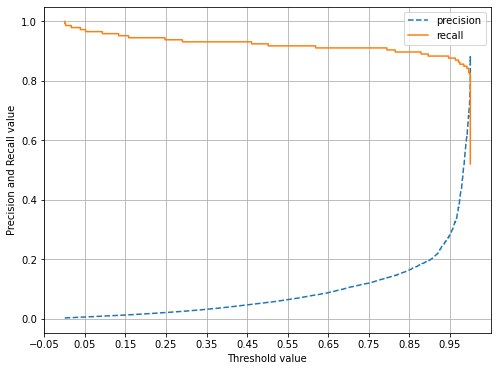

In [59]:
pred_proba_c1 = lr_clf.predict_proba(X_test)[:, 1]
precision_recall_curve_plot(y_test, pred_proba_c1)

### 임곗값에 따른 재현율과 정밀도(Trade off)
- 임곗값이 0.99 이하에서는 재현율이 매우 좋고 정밀도가 극단적으로 낮다가 0.99 이상에서는 반대로 재현율이 대폭 덜어지고 정밀도가 높아진다.
- 분류 결정 임계값을 조정하더라도 임계값의 민감도가 너무 심해 올바른 재현율/정밀도 성능을 얻을 수 없으므로 로지스틱 회귀 모델의 경우 SMOTE 적용 후 올바른 예측 모델이 생성되지 못했다.

In [ ]:
# LigthGBM 모델을 SMOTE로 오버 샘플링된 데이터 세트로 학습/예측/평가 수행
lgbm_clf = LGBMClassifier(n_estimators =1000, num_levels=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf, feature_train=X_train_over, feature_test = X_test, target_train =y_train, target_test=y_test)

# 재현율이 이상치만 제거한 경우인 82.88% 보다 높은 84.93%가 되었다.
# 그러나 정밀도는 이전의 96.8% 보다 낮은 93.23%이다.
# SMOTE를 적용하면 재현율은 높아지나, 정밀도는 낮아지는 것이 일반적이다.
# 좋은 SMOTE 패키지일수록 재현율 증가율은 높이고 정밀도 감소율은 낮출 수 있도록 효과적으로 데이터를 증식해야 한다.

### 인싸이트
- 불균형한 분포를 가진 피처를 로그 변환을 통해 불균형한 분포를 감소시켜주고 target값과 상관관계가 높은 피처의 이상치 데이터를 제거한 결과가 가장 좋게 나왔습니다.
- 재현율에서 상당히 큰 성능 개선을 볼 수 있습니다.
- 사기 적발 모델의 경우 실제 사기인 경우(1) 을 정상(0) 이라고 판단하게 되면 큰 문제가 발생할 수 있기 때문에 재현율이 중요한 지표로 사용됩니다.
    - 양성을 양성으로 판단하는 평가지표 -> 재현율 TP/(TP/FN)
    
이번 실습을 통해 데이터를 분석하고 전처리한 후 데이터에 맞는 머신러닝 알고리즘을 이용하여 학습, 예측, 성능 평가하는 전반적인 과정에 대해 이해할 수 있었습니다. 